# Chapter 11 - The Bootstrap Confidence Intervals

Implementing (and exploring) concepts from Computer Age Statistical Inference. Email me on sid \dot ravi1 \at gmail.com if you find any mistakes. This was written for learning purposes so apologies for the crappy varnames and inefficient code.

In [252]:
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import sympy as syp

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from theano import tensor as tt

## 11.1 Neyman's Construction for One-Parameter Problems

We won't calculate the sample correlation here but you could easily do that using pymc3. We'll just go with the analytical solution that they provide in chapter 3.

In [6]:
scores = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", sep=" ")
scores.head()

,mech,vecs,alg,analy,stat
0,7,51,43,17,22
1,44,69,53,53,53
2,49,41,61,49,64
3,59,70,68,62,56
4,34,42,50,47,29


In [390]:
syp.init_printing(use_unicode=False, wrap_line=False)
x = syp.Symbol('x')
theta = 0

theta_hat = 0.498
theta_hat_low = 0.093
theta_hat_high = 0.751

n = 22
pdf = []

for theta in tqdm(np.linspace(-1.0, 1.0, num=100)):
    
    log_first_term = np.log(n - 2) + ((n - 1)/2) * np.log(1 - theta**2) + ((n - 4)/2) * np.log(1 - theta_hat**2) - np.log(np.pi) 
    second_term = np.float32(syp.integrals.Integral((syp.functions.elementary.hyperbolic.cosh(x) - theta*theta_hat)**(1-n), (x, 0, syp.oo)).evalf())
    val = np.exp(log_first_term) * second_term
    
    log_first_term = np.log(n - 2) + ((n - 1)/2) * np.log(1 - theta**2) + ((n - 4)/2) * np.log(1 - theta_hat_low**2) - np.log(np.pi) 
    second_term = np.float32(syp.integrals.Integral((syp.functions.elementary.hyperbolic.cosh(x) - theta*theta_hat_low)**(1-n), (x, 0, syp.oo)).evalf())
    low_val = np.exp(log_first_term) * second_term
    
    log_first_term = np.log(n - 2) + ((n - 1)/2) * np.log(1 - theta**2) + ((n - 4)/2) * np.log(1 - theta_hat_high**2) - np.log(np.pi) 
    second_term = np.float32(syp.integrals.Integral((syp.functions.elementary.hyperbolic.cosh(x) - theta*theta_hat_high)**(1-n), (x, 0, syp.oo)).evalf())
    high_val = np.exp(log_first_term) * second_term
    
    pdf.append({'low': low_val, 'val':val, 'high':high_val, 'theta':theta})
    
    

In [418]:
pdf_df = pd.DataFrame(pdf)
pdf_df['val'] = pdf_df.val 
pdf_df['low'] = pdf_df.low 
pdf_df['high'] = pdf_df.high

In [527]:
mean_theta = (pdf_df['val']/ (pdf_df['val'].sum()) * np.linspace(-1.0, 1.0, num=100)).sum()
mean_theta

### Figure 11.1

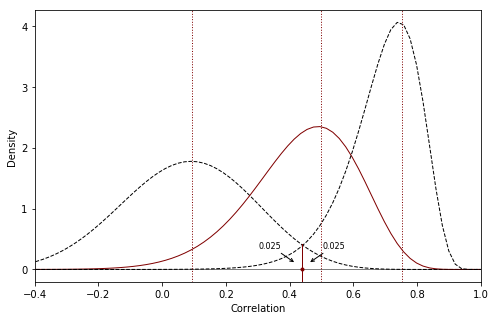

In [570]:
plt.figure(figsize=(8, 5))
theta_vals = np.linspace(-1.0, 1.0, num=100)
plt.plot(theta_vals, pdf_df.low, ls="--", color='k', lw=1.0)
plt.plot(theta_vals, pdf_df.val, color='maroon', lw=1.0)
plt.plot(theta_vals, pdf_df.high, ls="--", color='k', lw=1.0)
plt.axhline(y=0, color='k', lw = 0.5)
plt.plot(mean_theta, 0, ".", color='maroon')
plt.annotate("0.025", xy=(mean_theta-0.02, 0.1), xytext=(mean_theta - 0.1, 0.35), ha='center',
             xycoords='data', arrowprops = {'arrowstyle':'->'}, fontsize=8)

plt.annotate("0.025", xy=(mean_theta+0.02, 0.1), xytext=(mean_theta + 0.1, 0.35), ha='center',
             xycoords='data', arrowprops = {'arrowstyle':'->'}, fontsize=8)

plt.axvline(x=0.4391, ymin=0, ymax=0.14, lw= 1, color='maroon')
plt.axvline(x=0.498,lw= 1, ls = ':', color='maroon')

plt.axvline(x=0.093,  lw= 1, ls = ':', color='maroon')
plt.axvline(x=0.751,  lw= 1, ls = ':', color='maroon')

plt.xlim(-0.4, 1.0)
plt.yticks(ticks=np.arange(0, 5))
plt.xlabel("Correlation")
plt.ylabel("Density");

This is not quite what CASI has. Actually fig 11.1 doesn't match fig 3.2. The **MAP** is 0.498 not the **mean**, which is lower. I tried to get sample from the distribution with pymc3 and it also doesn't agree with what the book has.

In [323]:
x = scores[['mech','vecs']].values
with pm.Model() as m11_1:
    
    mu = pm.Normal('mu', 0, 100, shape=2)
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(10))
    L = pm.expand_packed_triangular(2, packed_L)
    sigma = pm.Deterministic('Σ', L.dot(L.T))
    
    obs = pm.MvNormal('obs', mu = mu, cov = sigma, observed =x)


In [324]:
trace = pm.sample(model=m11_1, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, mu]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:27<00:00, 877.08draws/s]


In [326]:
ro = trace['Σ'][:, 0, 1]/ (np.sqrt(trace['Σ'][:, 1, 1] * trace['Σ'][:, 0, 0]))

In [327]:
ro_hist = np.histogram(ro, 500)
ro_hist[1][np.argmax(ro_hist[0])], ro.mean()

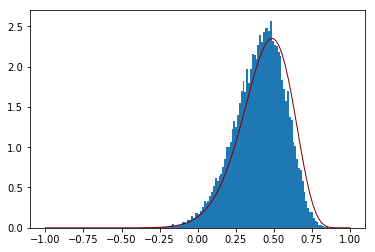

In [422]:
plt.hist(ro, bins=100, density=True);
plt.plot(theta_vals, pdf_df.val, color='maroon', lw=1.0)

### Figure 11.2: Transformational Invariance

In [491]:
def fisher_transform(x):
    x = np.float64(x)
    return 0.5 * (np.log( 1 + x) - np.log(1 - x))

transformed = fisher_transform(theta_vals)
pdf_df['trans_theta'] = transformed

In [492]:
def normalize(x, y):
    norm = ((x - x.shift(1)) * y).astype(float).fillna(0.0)
    norm2 = ((x.shift(-1) - x) * y).astype(float).fillna(0.0)
    norm_const = (norm[~np.isinf(norm)].sum() + norm2[~np.isinf(norm2)].sum())/2
    
    return y / norm_const

In [616]:
map_val = transformed[np.float32(norm_val).argmax() -1] #need to increase resolution. -1 seems like a better map value
map_low = transformed[np.float32(norm_low).argmax()]
map_high = transformed[np.float32(norm_high).argmax()]

18.185858


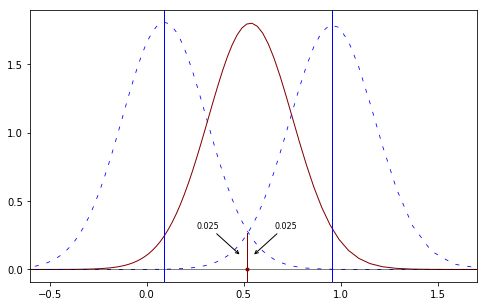

In [617]:
plt.figure(figsize=(8, 5))
norm_low = normalize(pdf_df['trans_theta'], pdf_df['low'])
norm_val = normalize(pdf_df['trans_theta'], pdf_df['val'])
norm_high = normalize(pdf_df['trans_theta'], pdf_df['high'])

plt.plot(transformed, norm_low, ls=(0, (5, 10)), color='b', lw=0.8)
plt.plot(transformed, norm_val, color='maroon', lw=1.0)
plt.plot(transformed, norm_high, ls=(0, (5, 10)), color='b', lw=0.8)
plt.axhline(y=0, color='k', lw = 0.5)
plt.xlim(-0.6, 1.7)
plt.yticks(np.arange(0, 2, 0.5));


plt.plot(map_val, 0, ".", color='maroon')
plt.annotate("0.025", xy=(map_val-0.03, 0.1), xytext=(map_val - 0.2, 0.30), ha='center',
            xycoords='data', arrowprops = {'arrowstyle':'->'}, fontsize=8)

plt.annotate("0.025", xy=(map_val+0.03, 0.1), xytext=(map_val + 0.2, 0.30), ha='center',
            xycoords='data', arrowprops = {'arrowstyle':'->'}, fontsize=8)

plt.axvline(x=map_val, ymin=0, ymax=0.18, lw= 1, color='maroon')
plt.axvline(x=map_low, lw= 1, color='blue')
plt.axvline(x=map_high+0.01, lw= 1, color='blue')

mean_theta_trans = (transformed * norm_val).astype('float32').fillna(0.0).sum()
print(mean_theta_trans)

## 11.2 Percentile Method

In [645]:
def get_bootstrap(estimator_func, data, n_reps):

    # bootstrap
    theta_hats = np.full(n_reps, np.nan)

    for i in range(n_reps):

        idx = np.random.randint(0, data.shape[0], data.shape[0])
        theta_hats[i] = estimator_func(data[idx].T)

    return theta_hats

In [861]:
x = scores[['mech','vecs']].values
bstrap_est = get_bootstrap(lambda x: np.corrcoef(x)[0][1], x, 2000)
mu = bstrap_est.mean()
perc2_5, perc97_5= np.percentile(bstrap_est, q=[2.5, 97.5])
perc2_5, perc97_5

### Figure 11.3

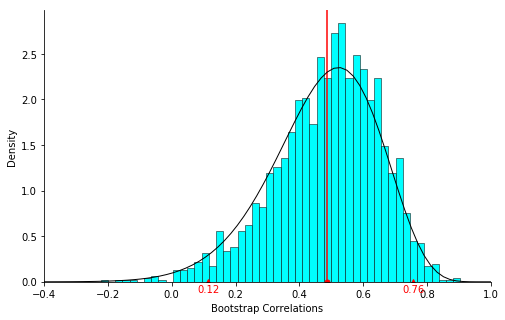

In [862]:
f, ax = plt.subplots(figsize=(8,5))
ax.hist(bstrap_est, bins=50, density=True, ec='k', color='cyan', lw=0.5);
ax.axvline(x=mu, color='red', lw=1.5)
ax.plot(mu, 0, ".", ms=10, color='r')

ax.plot(perc2_5, 0, "^", color='r')
ax.annotate("{:0.2f}".format(perc2_5), color='r', xy=(perc2_5, 0), ha='center', xytext= (perc2_5, -0.12, ))

ax.plot(perc97_5, 0, "^", color='r')
ax.annotate("{:0.2f}".format(perc97_5), color='r', xy=(perc97_5, 0),ha='center',  xytext= (perc97_5, -0.12, ))
ax.set_xlabel("Bootstrap Correlations")
ax.set_ylabel("Density")
# manually correcting the bias to make the function match the hist. 
# Not sure where the error is coming from
ax.plot(theta_vals + 0.034, pdf_df.val, color='k', lw=1.0) 

ax.set_xticks(np.arange(-0.4, 1.1, 0.2))
tr = ax.get_xaxis_transform()
ax.set_xlim(-0.4, 1.0)
sns.despine()

### Figure 11.4

In [965]:
std_low = bstrap_est.mean() + sp.stats.norm.ppf(0.025)*bstrap_est.std()
std_high = bstrap_est.mean() + sp.stats.norm.ppf(0.975)*bstrap_est.std()

ci_vals = {}
ci_vals['Standard'] = {'theta_low':std_low, 'theta_high':std_high}
ci_vals['Exact'] = {'theta_low':.093, 'theta_high':0.751}

In [966]:
bins, vals = np.histogram(bstrap_est, bins=2000)
xvals = (vals[:-1] + vals[1:])/2
bin_sums = bins.cumsum() / 2000
idx_high = (np.abs(bin_sums - 0.975)).argmin()
idx_low = (np.abs(bin_sums - 0.025)).argmin()
ci_vals['Percentile'] = {'theta_low':xvals[idx_low], 'theta_high': xvals[idx_high]}

Text(0.9249898053309824, 1.0, '$\\hat{G}$')

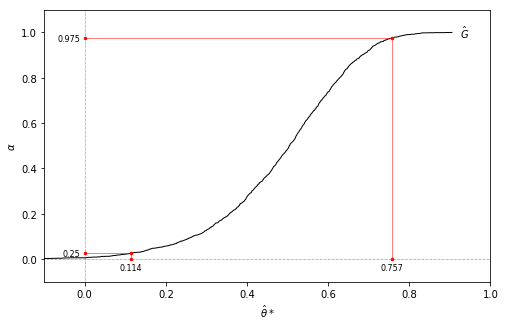

In [911]:
f, ax = plt.subplots(figsize=(8,5))
ax.plot(xvals, bins.cumsum() / 2000, 'k', lw=1.0)
ax.axhline(0, ls=":", lw=0.5, c='k')
ax.axvline(0, ls=":", lw=0.5, c='k')
ax.set_xlim(-0.1, 1.0);
ax.set_ylim(-0.1, 1.1);
ax.set_xlabel(r'$\hat{\theta}*$')
ax.set_ylabel(r'$\alpha$');

plt.plot([ 0, xvals[idx_low], xvals[idx_low]], [bin_sums[idx_low], bin_sums[idx_low], 0], '.-r', lw=0.5,  ms=5)
plt.plot([ 0, xvals[idx_high], xvals[idx_high]], [bin_sums[idx_high], bin_sums[idx_high], 0], '.-r', lw=0.5,  ms=5)

#plt.plot([ 0, xvals[idx_low], xvals[idx_low]], [bin_sums[idx_low], bin_sums[idx_low], 0], 'r')
plt.annotate("0.25", [-.01, bin_sums[idx_low]], ha='right', va='center', fontsize=8)
plt.annotate("0.975", [-.01, bin_sums[idx_high]], ha='right', va='center', fontsize=8)
plt.annotate("{:0.3f}".format(xvals[idx_low]), [xvals[idx_low], -0.02], ha='center', va='top', fontsize=8)
plt.annotate("{:0.3f}".format(xvals[idx_high]), [xvals[idx_high], -0.02], ha='center', va='top', fontsize=8)


plt.annotate(r'$\hat{G}$', (xvals.max() + 0.02, 1.0), va='center')


## 11.3 Bias-Corrected Confidence Intervals

**Check for bias based on (11.30):** We are not doing an exact integration on the function but instead using an approximation using the point generated from the function.

In [881]:
p0 = (theta_vals[theta_vals < 0.498] * pdf_df['val'][theta_vals < 0.498]).sum() / (theta_vals * pdf_df['val']).sum()
p0

This is what the authors get. Not exactly 0.50 so this suggests that $\hat{\theta}$ is upward biased.
Next we find the bias correction value and calculate $\hat{\theta}_{BC}$

In [967]:
z0 = sp.stats.norm.ppf(np.float(p0))
θ_2_5 = sp.stats.norm.cdf(2*z0 + sp.stats.norm.ppf(0.025))
θ_97_5 = sp.stats.norm.cdf(2*z0 + sp.stats.norm.ppf(0.975))
z0, θ_2_5, θ_97_5

In [968]:
idx_high = (np.abs(bin_sums - θ_97_5)).argmin()
idx_low = (np.abs(bin_sums - θ_2_5)).argmin()

ci_vals['BC'] = {'theta_low':xvals[idx_low], 'theta_high': xvals[idx_high]}

## 11.4 Second-Order Accuracy

In [969]:
a = 0.005

θbc_2_5 = sp.stats.norm.cdf(z0 + ((z0 + sp.stats.norm.ppf(0.025)) / (1 - a*(z0 + sp.stats.norm.ppf(0.025)))))
θbc_97_5 = sp.stats.norm.cdf(z0 + ((z0 + sp.stats.norm.ppf(0.975)) / (1 - a*(z0 + sp.stats.norm.ppf(0.975)))))

θbc_2_5, θbc_97_5

In [970]:
idx_high = (np.abs(bin_sums - θbc_97_5)).argmin()
idx_low = (np.abs(bin_sums - θbc_2_5)).argmin()

ci_vals['BCa'] = {'theta_low':xvals[idx_low], 'theta_high': xvals[idx_high]}

In [972]:
df = pd.DataFrame(ci_vals).T
df.loc[['Standard','Percentile','BC', 'BCa', 'Exact']].round(2)

,theta_high,theta_low
Standard,0.81,0.17
Percentile,0.76,0.11
BC,0.74,0.09
BCa,0.75,0.09
Exact,0.75,0.09


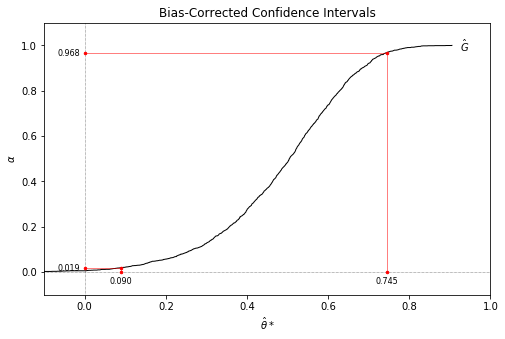

In [909]:
f, ax = plt.subplots(figsize=(8,5))
ax.plot(xvals, bins.cumsum() / 2000, 'k', lw=1.0)
ax.axhline(0, ls=":", lw=0.5, c='k')
ax.axvline(0, ls=":", lw=0.5, c='k')
ax.set_xlim(-0.1, 1.0);
ax.set_ylim(-0.1, 1.1);
ax.set_xlabel(r'$\hat{\theta}*$')
ax.set_ylabel(r'$\alpha$');

plt.plot([ 0, xvals[idx_low], xvals[idx_low]], [bin_sums[idx_low], bin_sums[idx_low], 0], '.-r', lw=0.5,  ms=5)
plt.plot([ 0, xvals[idx_high], xvals[idx_high]], [bin_sums[idx_high], bin_sums[idx_high], 0], '.-r', lw=0.5,  ms=5)

#plt.plot([ 0, xvals[idx_low], xvals[idx_low]], [bin_sums[idx_low], bin_sums[idx_low], 0], 'r')
plt.annotate("{:0.3f}".format(bin_sums[idx_low]), [-.01, bin_sums[idx_low]], ha='right', va='center', fontsize=8)
plt.annotate("{:0.3f}".format(bin_sums[idx_high]), [-.01, bin_sums[idx_high]], ha='right', va='center', fontsize=8)
plt.annotate("{:0.3f}".format(xvals[idx_low]), [xvals[idx_low], -0.02], ha='center', va='top', fontsize=8)
plt.annotate("{:0.3f}".format(xvals[idx_high]), [xvals[idx_high], -0.02], ha='center', va='top', fontsize=8)

plt.title("Bias-Corrected Confidence Intervals")
plt.annotate(r'$\hat{G}$', (xvals.max() + 0.02, 1.0), va='center');


In [984]:
pois10 = sp.stats.poisson(10.0).rvs(5000)
10 - 1.96 * 10**(1/2)

### Table 11.2

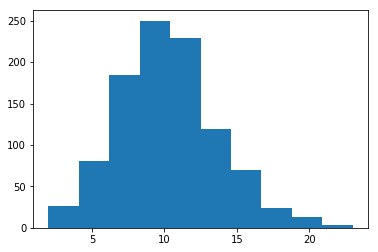

In [1008]:
plt.hist(sp.stats.poisson(10.5).rvs(1000));

In [1020]:
10**(5.08) * np.exp(-10) / (np.math.gamma(5.08 + 1))

In [1025]:
10**5 * np.exp(-10) / (np.math.factorial(np.round(5)))

In [1029]:
sp.stats.poisson(10).pmf([6, 7, 8 , 9 ,10,11, 12])

array([0.06305546, 0.09007923, 0.11259903, 0.12511004, 0.12511004,
       0.1137364 , 0.09478033])